<a href="https://colab.research.google.com/github/Akkki28/ResNet-On-Fruits/blob/main/ResNetOnFruits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools

In [ ]:
IMAGE_SIZE = [100, 100]

epochs = 1
batch_size = 128

In [ ]:
!wget -nc https://archive.org/download/fruits-360/fruits-360.zip

--2024-01-30 16:27:59--  https://archive.org/download/fruits-360/fruits-360.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia601203.us.archive.org/24/items/fruits-360/fruits-360.zip [following]
--2024-01-30 16:27:59--  https://ia601203.us.archive.org/24/items/fruits-360/fruits-360.zip
Resolving ia601203.us.archive.org (ia601203.us.archive.org)... 207.241.227.133
Connecting to ia601203.us.archive.org (ia601203.us.archive.org)|207.241.227.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190820824 (182M) [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip      100%[===================>] 181.98M  2.42MB/s    in 2m 23s  

2024-01-30 16:30:22 (1.27 MB/s) - ‘fruits-360.zip’ saved [190820824/190820824]



In [ ]:
!unzip -nq fruits-360.zip

In [ ]:
train_path = 'fruits-360/Training'
valid_path = 'fruits-360/Validation'

In [ ]:
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [ ]:
folders = glob(train_path + '/*')


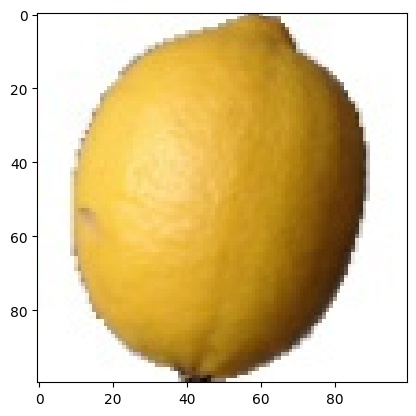

In [ ]:
plt.imshow(image.load_img(np.random.choice(image_files)));

In [ ]:
res = ResNet50(
    input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
for layer in res.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(res.output)

prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
model = Model(inputs=res.input, outputs=prediction)

In [ ]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [ ]:
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 9673 images belonging to 60 classes.
{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Carambula': 16, 'Cherry': 17, 'Clementine': 18, 'Cocos': 19, 'Dates': 20, 'Granadilla': 21, 'Grape Pink': 22, 'Grape White': 23, 'Grape White 2': 24, 'Grapefruit Pink': 25, 'Grapefruit White': 26, 'Guava': 27, 'Huckleberry': 28, 'Kaki': 29, 'Kiwi': 30, 'Kumquats': 31, 'Lemon': 32, 'Lemon Meyer': 33, 'Limes': 34, 'Litchi': 35, 'Mandarine': 36, 'Mango': 37, 'Maracuja': 38, 'Nectarine': 39, 'Orange': 40, 'Papaya': 41, 'Passion Fruit': 42, 'Peach': 43, 'Peach Flat': 44, 'Pear': 45, 'Pear Abate': 46, 'Pear Monster': 47, 'Pear Williams': 48, 'Pepino': 49, 'Pineapple': 50, 'Pitahaya Red': 51, 'Plum': 52, 'Pomegranate': 53, 'Quince': 54, 'Ra

min: -108.779 max: 151.061


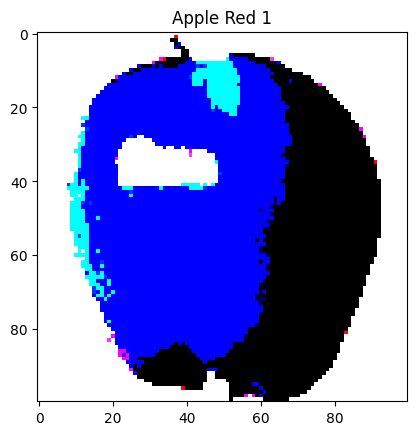

In [ ]:
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [ ]:
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 28736 images belonging to 60 classes.
Found 9673 images belonging to 60 classes.


In [ ]:
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

224/224 [==============================] - 1937s 9s/step - loss: 0.1513 - accuracy: 0.9749 - val_loss: 0.3902 - val_accuracy: 0.9552


In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();